In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from sklearn.svm import LinearSVC, LinearSVR
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from pmdarima import utils, arima, model_selection
import pmdarima as pm

In [3]:
df = pd.read_pickle("../data/df_kappa.pickle")
df.head()

,kappa,node,edge
0,16.758163,471,2003
1,18.356171,487,2194
2,23.953381,514,2863
3,15.620315,470,1867
4,18.657366,495,2230


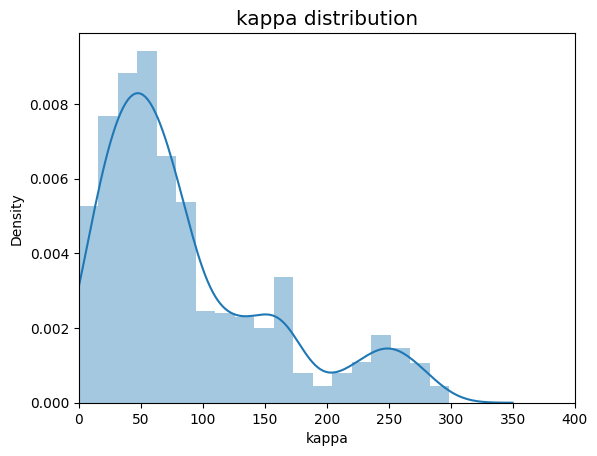

In [4]:
# kappaの分布
sns.distplot(df["kappa"])
# 幅は0から
# plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.xlim(0, 400)
plt.title("kappa distribution")
plt.savefig("../fig/kappa_distribution.png")
plt.show()

In [5]:
df["timestamp"] = pd.date_range(start="2020-04-01", end="2023-09-21", freq="D")

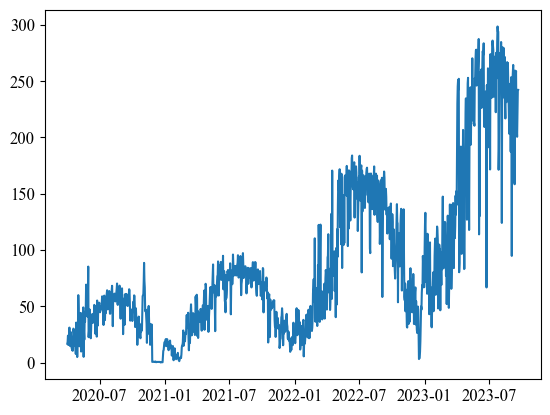

In [6]:
# kappaをプロットする
plt.plot(df["timestamp"], df["kappa"])

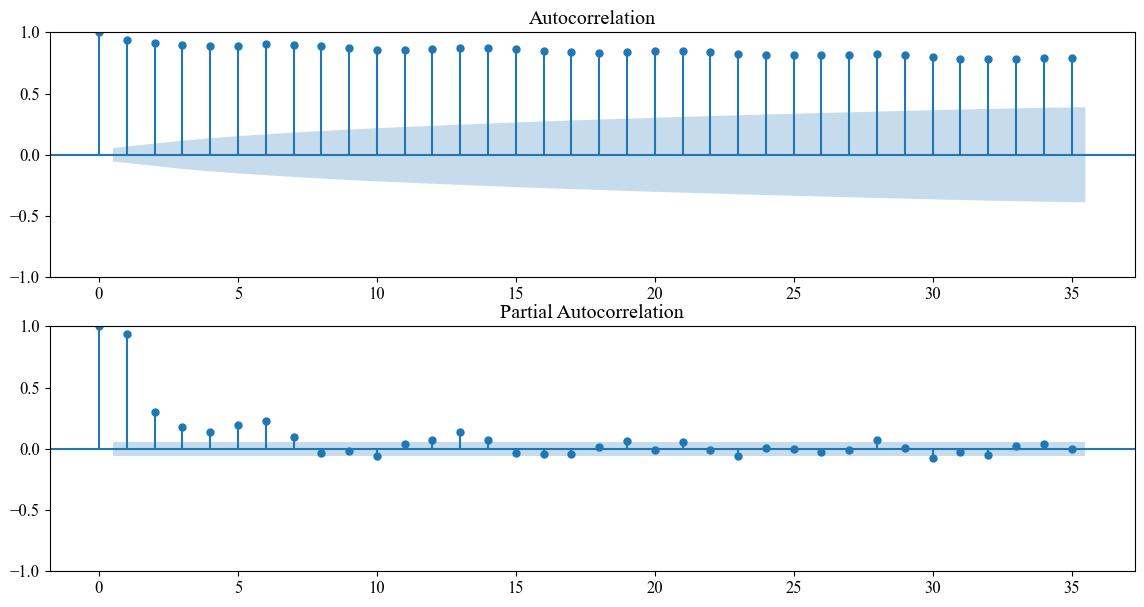

In [9]:
# 自己相関
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.kappa, lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.kappa, lags=35, ax=ax2)

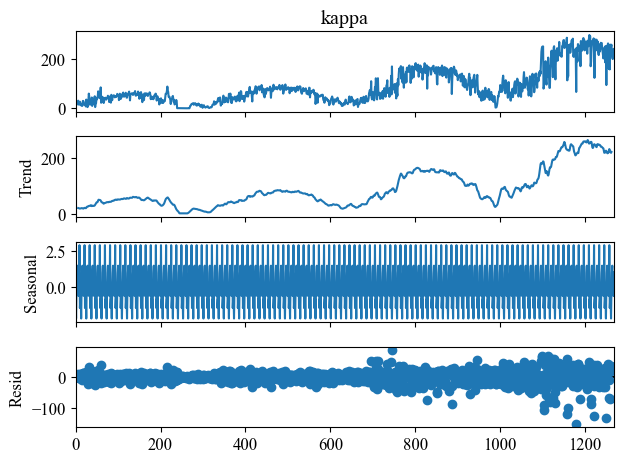

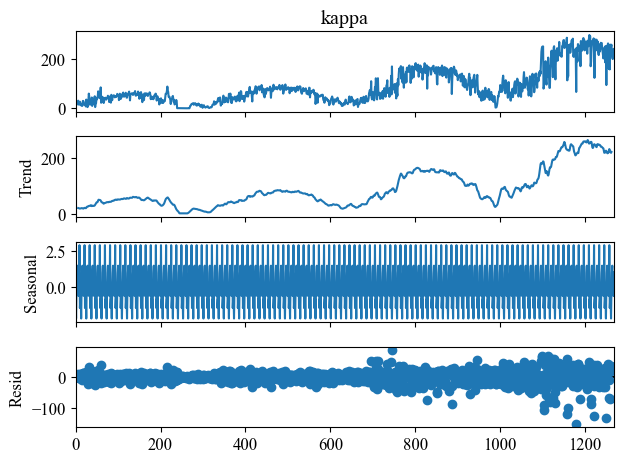

In [300]:
# トレンドと季節成分に分解
sdr = sm.tsa.seasonal_decompose(df.kappa, period=12, two_sided=True)
sdr.plot()

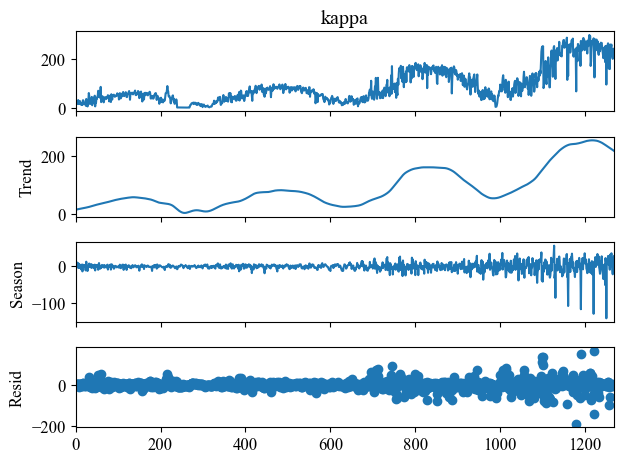

In [303]:
stl = STL(df.kappa, period=30, robust=True)
stl_series = stl.fit()
stl_series.plot()
plt.show()

In [12]:
ct = sm.tsa.stattools.adfuller(df.kappa, regression="ct") # トレンド項あり
c = sm.tsa.stattools.adfuller(df.kappa, regression="c")
nc = sm.tsa.stattools.adfuller(df.kappa, regression="n")

In [13]:
print("ct:")
print(ct[1])
print("+--------------------+")
print("c:")
print(c[1])
print("+--------------------+")
print("nc:")
print(nc[1])
print("+--------------------+")

ct:
0.7291659450310539
+--------------------+
c:
0.8742432704234948
+--------------------+
nc:
0.8503696728977612
+--------------------+


In [14]:
# kappa階差
diff = df.kappa.diff()
diff = diff.dropna()

In [16]:
ct = sm.tsa.stattools.adfuller(diff, regression="ct") # トレンド項あり
c = sm.tsa.stattools.adfuller(diff, regression="c")
nc = sm.tsa.stattools.adfuller(diff, regression="n")

print("ct:")
print(ct[1])
print("+--------------------+")
print("c:")
print(c[1])
print("+--------------------+")
print("nc:")
print(nc[1])
print("+--------------------+") # 全部棄却出来た

ct:
9.145303476287276e-15
+--------------------+
c:
1.0980325549387373e-16
+--------------------+
nc:
7.066531742706902e-17
+--------------------+


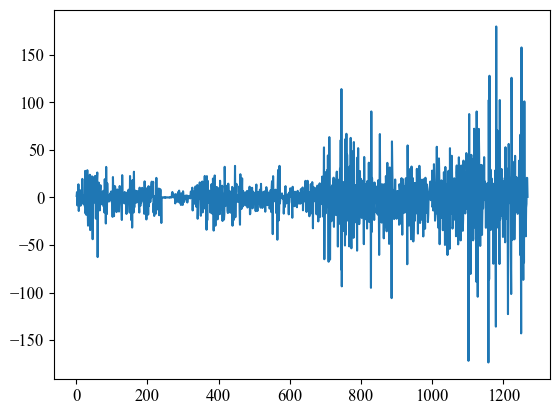

In [17]:
plt.plot(diff)

## モデル推定

In [18]:
train = df[df.timestamp < "2021-09-01"]
test = df[df.timestamp >= "2021-09-01"]

## 移動平均

In [43]:
kappa_ma = np.convolve(df.kappa, np.ones(10), mode="valid") / 10
print("Moving Average", kappa_ma)

Moving Average [ 19.25055316  20.27879992  20.67704684 ... 224.20387184 225.69017158
 234.07257138]


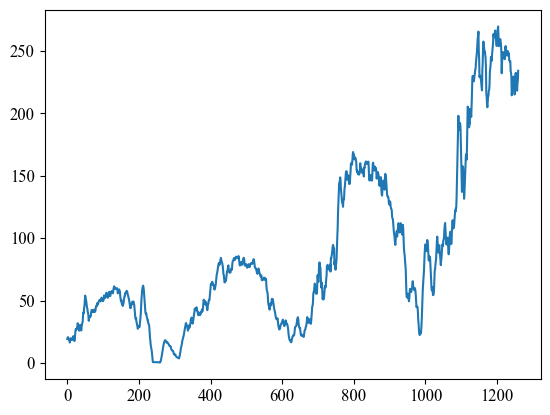

In [44]:
plt.plot(kappa_ma)

## 自己相関関数

In [79]:
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

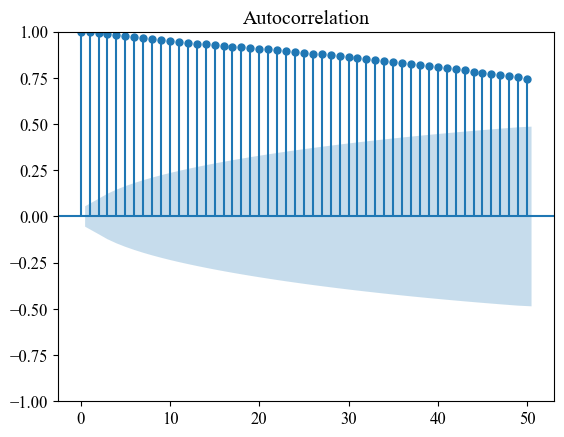

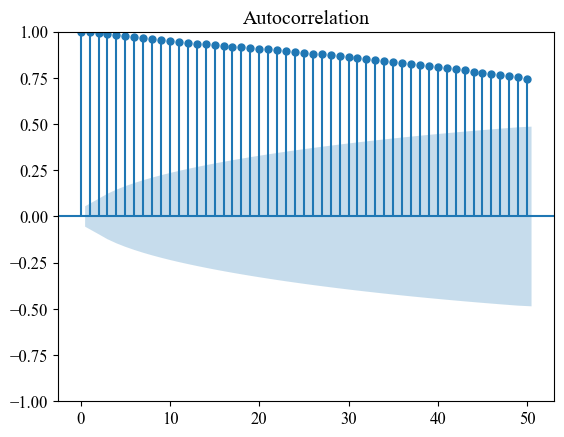

In [49]:
plot_acf(kappa_ma, lags=50)

In [51]:
# 対数変換
kappa_log = np.log(df.kappa)
print(kappa_log)

0       2.818886
1       2.909966
2       3.176109
3       2.748572
4       2.926241
          ...   
1264    5.334947
1265    5.301410
1266    5.399293
1267    5.487673
1268    5.490065
Name: kappa, Length: 1269, dtype: float64


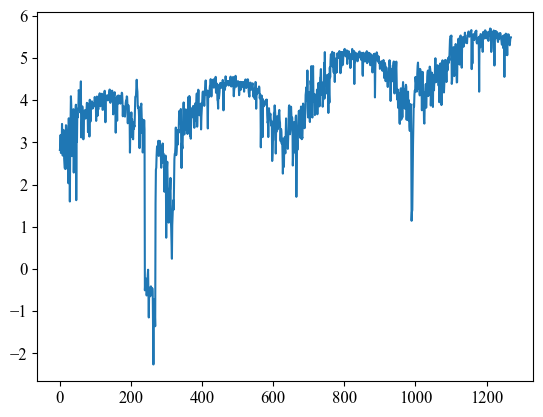

In [52]:
plt.plot(kappa_log)

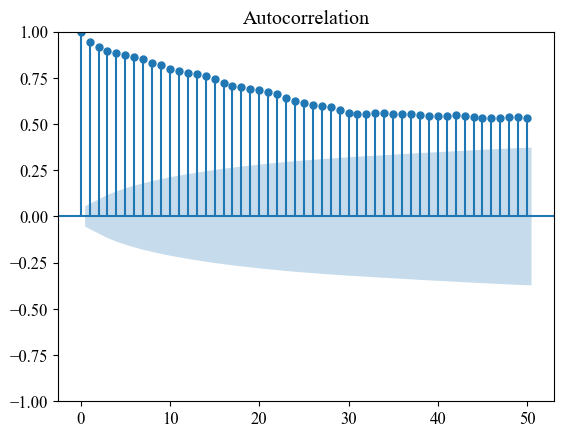

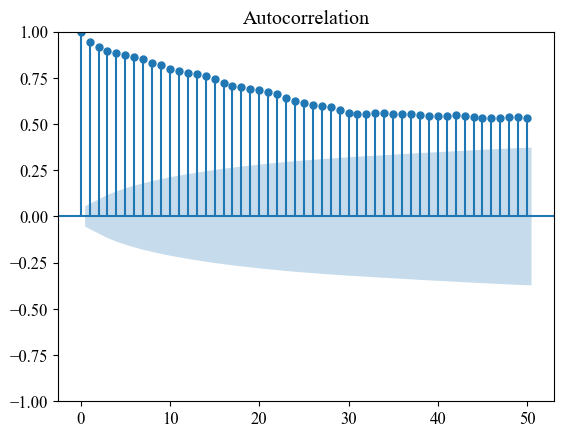

In [54]:
plot_acf(kappa_log, lags=50)

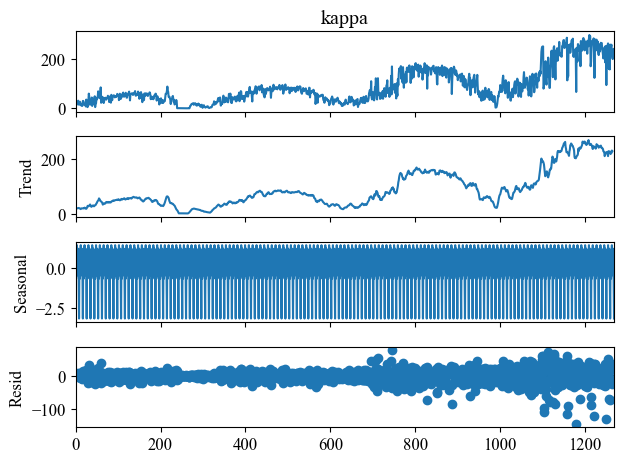

In [59]:
# 成分分解
res = sm.tsa.seasonal_decompose(df.kappa, model="additive", period=9)
res.plot()
plt.show()

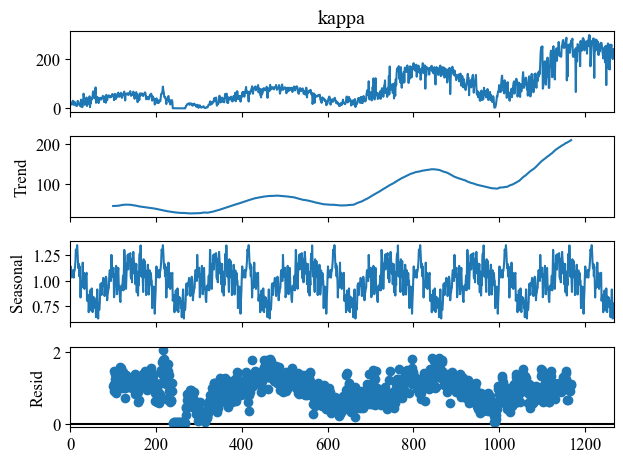

In [68]:
# 移動平均法を利用した分解
res = sm.tsa.seasonal_decompose(df.kappa, model="multiplicative", period=200)
res.plot()
plt.show()

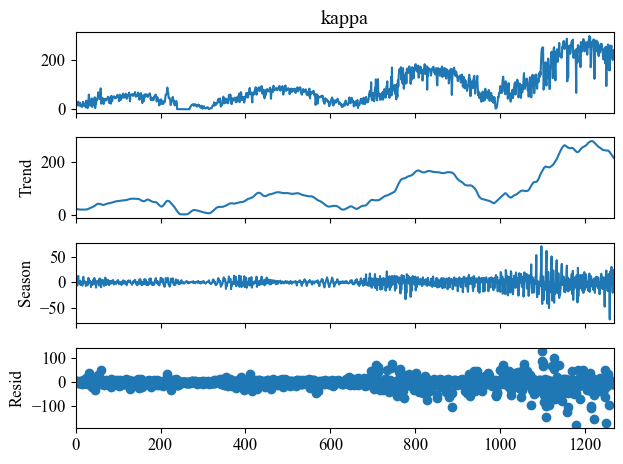

In [71]:
# STL分解
stl = sm.tsa.STL(df.kappa, period=12, robust=True).fit()
stl.plot()
plt.show()

In [73]:
# ADF検定
dftest = sm.tsa.adfuller(df.kappa)

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1]) # 有意でない。時系列は非定常
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -0.585417
p-value: 0.874243
Critical values :
	 1% -3.4356090875394525
	 5% -2.863862410805964
	 10% -2.568006480268158


In [76]:
# 対数変換したもののADF検定
dftest = sm.tsa.adfuller(kappa_log)

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1]) # log変換したら定常
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -3.082274
p-value: 0.027893
Critical values :
	 1% -3.4355796466416777
	 5% -2.863849421064024
	 10% -2.5679995625056926


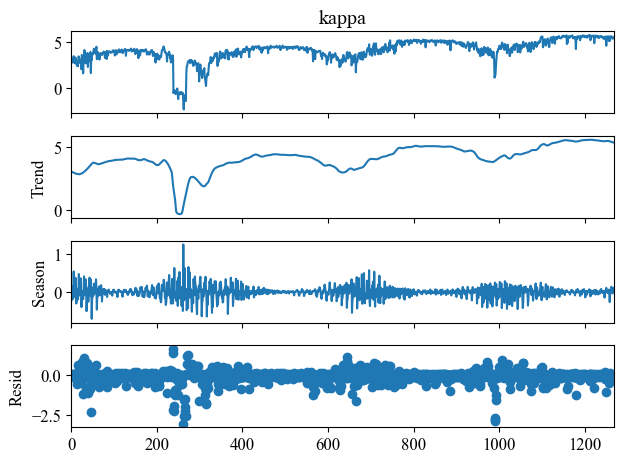

In [77]:
# 対数変換してSTL分解する
stl = sm.tsa.STL(kappa_log, period=12, robust=True).fit()
stl.plot()
plt.show()

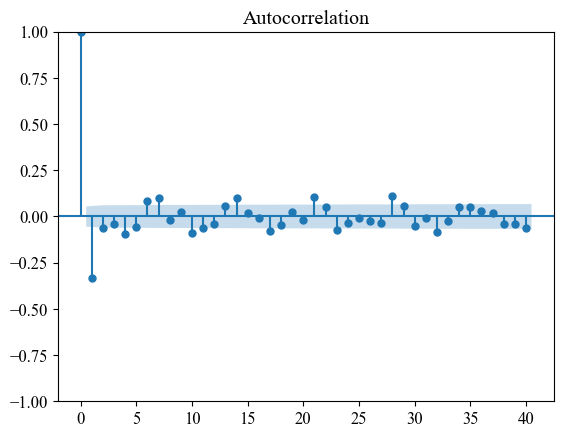

In [78]:
acf = plot_acf(np.diff(df.kappa, 1), lags=40)

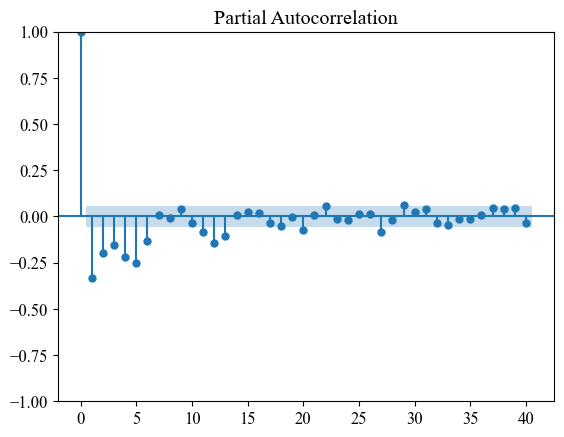

In [80]:
pacf = plot_pacf(np.diff(df.kappa, 1), lags=40)

In [154]:
# 訓練データとテストデータに分ける
train = df.iloc[:-365, :]
test = df.iloc[-365:, :]

In [155]:
train_kappa = train["kappa"]

In [156]:
test_kappa = test["kappa"]

In [157]:
# 単純指数平滑化法モデル
SES_model = SimpleExpSmoothing(train_kappa)
SES_model_fit = SES_model.fit(smoothing_level=0.5)

SES_pred = SES_model_fit.forecast(365)

print('RMSE:')
print(np.sqrt(mean_squared_error(test_kappa, SES_pred)))
print('MAE:')
print(mean_absolute_error(test_kappa, SES_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(test_kappa, SES_pred))

RMSE:
85.65016209438139
MAE:
72.05357515201199
MAPE:
0.9176586578266327


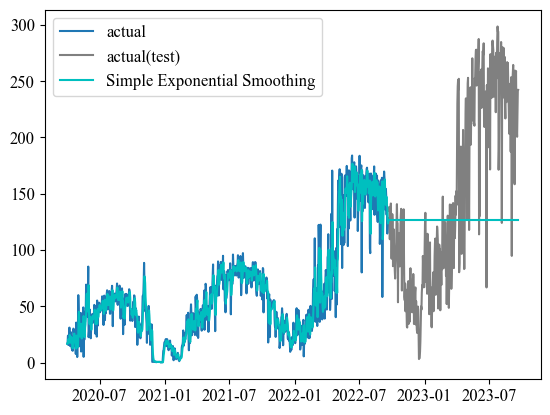

In [158]:
fig, ax = plt.subplots()
ax.plot(train.timestamp, train_kappa, label="actual")
ax.plot(test.timestamp, test_kappa, label="actual(test)", color="gray")
ax.plot(train.timestamp, SES_model_fit.fittedvalues, color="c")
ax.plot(test.timestamp, SES_pred, label="Simple Exponential Smoothing", color="c")
plt.legend()

In [159]:
# Holtの線形指数平滑法モデル
Holt_model = Holt(train_kappa)
Holt_model_fit = Holt_model.fit(smoothing_level=.3,
                                smoothing_trend=.2)

In [160]:
Holt_pred = Holt_model_fit.forecast(365)

print('RMSE:')
print(np.sqrt(mean_squared_error(test_kappa, Holt_pred)))
print('MAE:')
print(mean_absolute_error(test_kappa, Holt_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(test_kappa, Holt_pred))

RMSE:
611.5178857961132
MAE:
505.5892298323559
MAPE:
3.4624537834312887


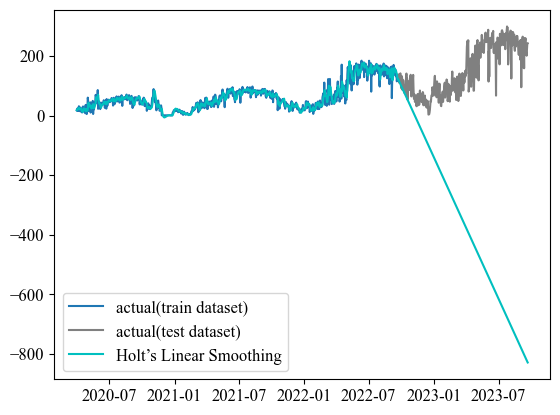

In [161]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(train.timestamp, train_kappa.values, label="actual(train dataset)")
ax.plot(test.timestamp, test_kappa.values, label="actual(test dataset)", color="gray")
ax.plot(train.timestamp, Holt_model_fit.fittedvalues, color="c")
ax.plot(test.timestamp, Holt_pred, label="Holt’s Linear Smoothing", color="c") 
plt.legend()

In [165]:
# Holt-Winters Seasonal Smoothing model
HW_model = ExponentialSmoothing(train_kappa,
                               trend="additive",
                               seasonal="additive",
                               seasonal_periods=24)
HW_model_fit = HW_model.fit()

In [166]:
HW_pred = HW_model_fit.forecast(365)

print('RMSE:')
print(np.sqrt(mean_squared_error(test_kappa, HW_pred)))
print('MAE:')
print(mean_absolute_error(test_kappa, HW_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(test_kappa, HW_pred))

RMSE:
71.2259921189054
MAE:
63.391018576583846
MAPE:
0.9846801575590326


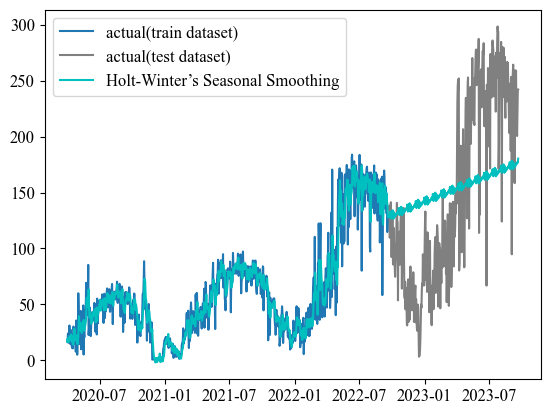

In [167]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(train.timestamp, train_kappa.values, label="actual(train dataset)")
ax.plot(test.timestamp, test_kappa.values, label="actual(test dataset)", color="gray")
ax.plot(train.timestamp, HW_model_fit.fittedvalues, color="c")
ax.plot(test.timestamp, HW_pred, label="Holt-Winter’s Seasonal Smoothing", color="c") 
plt.legend()

In [169]:
# ARIMAモデル
df_train, df_test = model_selection.train_test_split(df, test_size=365)

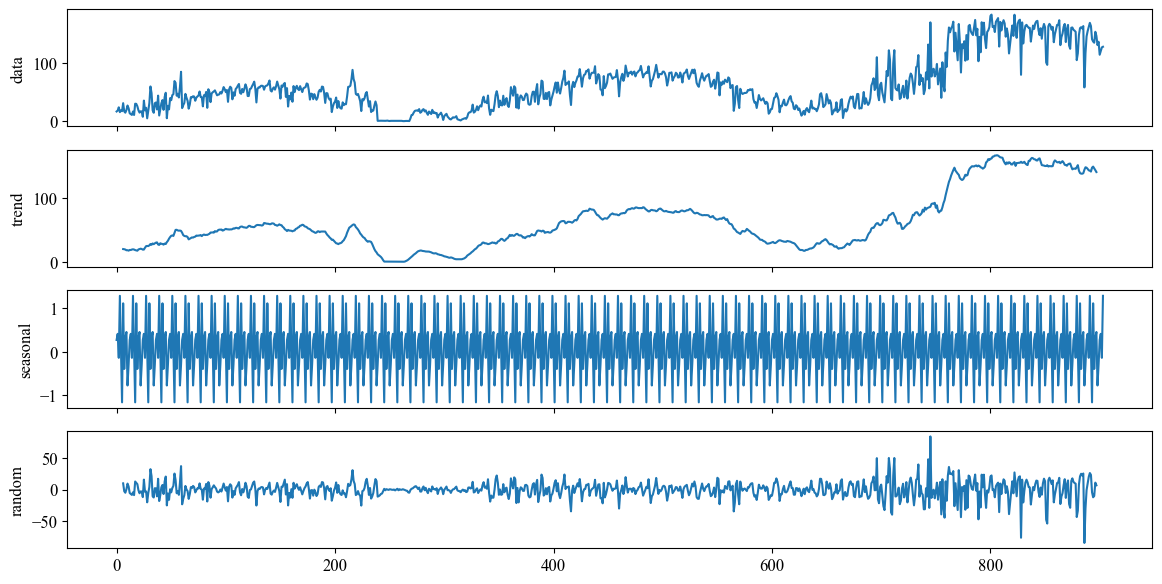

In [173]:
utils.decomposed_plot(arima.decompose(df_train["kappa"], "additive", m=12),
                     figure_kwargs={"figsize":(14, 7)})

In [194]:
# 階差の次数の検討
print("d =", arima.ndiffs(df["kappa"]))
print("D =", arima.nsdiffs(df["kappa"], m=24))

d = 1
D = 0


In [267]:
arima_model = pm.auto_arima(df_train["kappa"],
                           seasonal=True,
                           m=12,
                           trace=True,
                           n_jobs=-1,
                           maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7460.912, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7732.983, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7594.225, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7479.999, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7731.028, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7458.861, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7457.299, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7458.910, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7455.992, Time=0.11 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7459.472, Time=0.34 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7458.066, Time=0.63 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7462.918, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=7459.056, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7454.851, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0

In [212]:
train_pred = arima_model.predict_in_sample()

test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test["kappa"].shape[0],
    return_conf_int=True
)

In [213]:
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test["kappa"], test_pred)))
print('MAE:')
print(mean_absolute_error(df_test["kappa"], test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test["kappa"], test_pred))

RMSE:
84.18578175500564
MAE:
72.17306339377957
MAPE:
0.9586745006174096


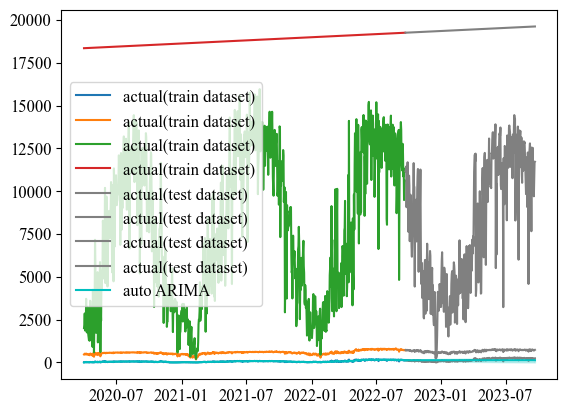

In [217]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train.timestamp, df_train.values, label="actual(train dataset)")
ax.plot(df_test.timestamp, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train.timestamp, train_pred, color="c")
ax.plot(df_test.timestamp, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.timestamp,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [219]:
arima_model = pm.auto_arima(train["kappa"],
                           seasonal=True,
                           m=12,
                           d=1,
                           D=0,
                           trace=True,
                           n_jobs=-1,
                           maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7460.912, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7732.983, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7594.225, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7479.999, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7731.028, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7458.861, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7457.299, Time=0.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7458.910, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=7455.992, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7459.472, Time=0.35 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7458.066, Time=0.73 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7462.918, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=7459.056, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7454.851, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0

In [223]:
train_pred = arima_model.predict_in_sample()

test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0],
    return_conf_int=True
)

print("RMSE")
print(np.sqrt(mean_squared_error(df_test["kappa"], test_pred)))
print('MAE:')
print(mean_absolute_error(df_test["kappa"], test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test["kappa"], test_pred))

RMSE
84.18288275450439
MAE:
72.19622092361963
MAPE:
0.9591851174634507


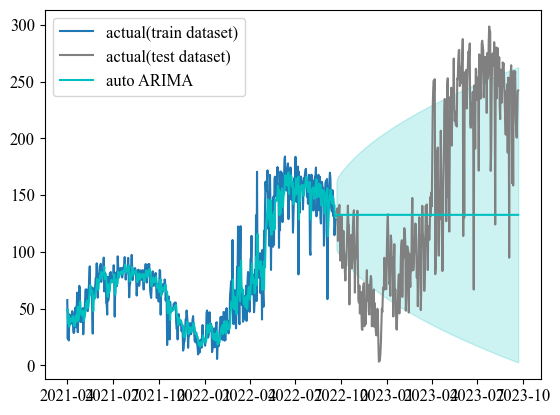

In [229]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[365:].timestamp, df_train[365:]["kappa"], label="actual(train dataset)")
ax.plot(df_test.timestamp, df_test["kappa"], label="actual(test dataset)", color="gray")
ax.plot(df_train[365:].timestamp, train_pred[365:], color="c")
ax.plot(df_test.timestamp, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.timestamp,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

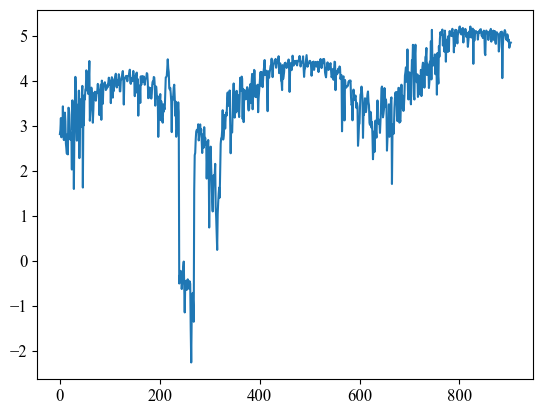

In [234]:
# 対数系列
df_log = np.log(df_train["kappa"])

plt.plot(df_log)

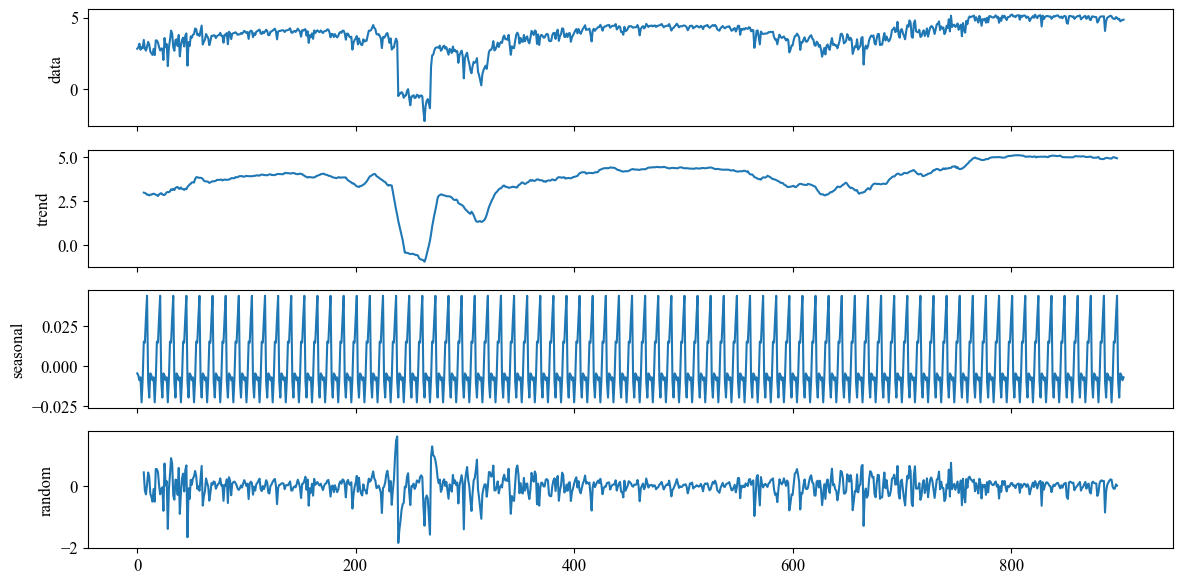

In [236]:
# 成分分解
utils.decomposed_plot(arima.decompose(df_log, "additive", m=12),
                     figure_kwargs={"figsize":(14, 7)})

In [242]:
print("d = ", arima.ndiffs(df_log))
print("D = ", arima.nsdiffs(df_log, m=12))

d =  1
D =  0


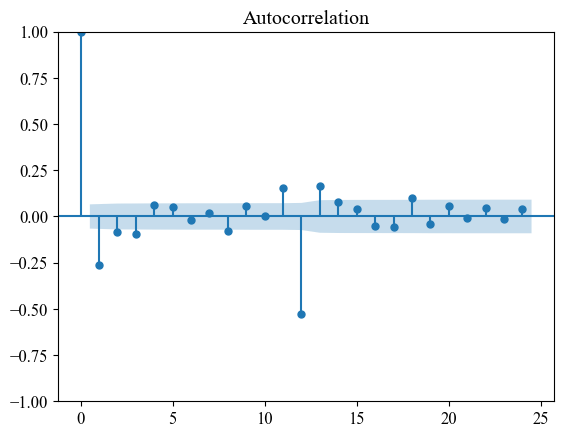

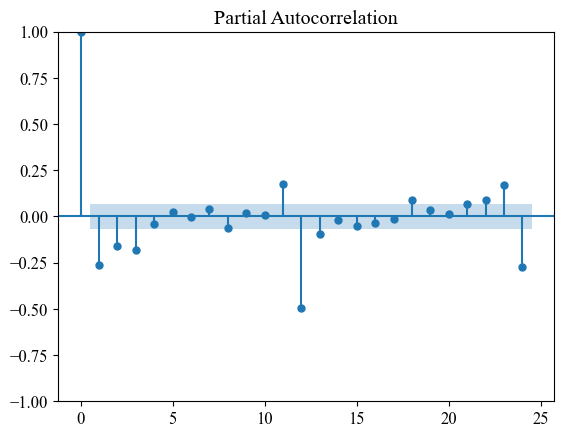

In [243]:
data = df_log.diff(1).diff(12).dropna()

utils.plot_acf(data, alpha=.05, lags=24)
utils.plot_pacf(data, alpha=.05, lags=24)

In [246]:
train = df_log

In [273]:
print(train)

0      2.818886
1      2.909966
2      3.176109
3      2.748572
4      2.926241
         ...   
899    4.920851
900    4.742138
901    4.793611
902    4.847604
903    4.855636
Name: kappa, Length: 904, dtype: float64


In [268]:
arima_model = pm.auto_arima(train,
                           seasonal=True,
                           m=12,
                           trace=True,
                           n_jobs=-1,
                           maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=762.512, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=854.179, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=801.548, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=774.341, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=852.210, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=760.873, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=761.253, Time=0.12 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=762.016, Time=1.63 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=760.362, Time=0.48 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=761.736, Time=1.28 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=763.641, Time=1.75 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=760.491, Time=0.34 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=779.258, Time=0.42 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=760.280, Time=0.54 sec
 ARIMA(3,1,2)(0,0,0)[12] intercep

In [269]:
train_pred_log = arima_model.predict_in_sample()
train_pred = np.exp(train_pred_log)

test_pred_log, test_pred_ci_log = arima_model.predict(
    n_periods=df_test.shape[0],
    return_conf_int=True
)
test_pred = np.exp(test_pred_log)
test_pred_ci = np.exp(test_pred_ci_log)

In [270]:
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test["kappa"], test_pred)))
print('MAE:')
print(mean_absolute_error(df_test["kappa"], test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test["kappa"], test_pred))

RMSE:
85.39671944609901
MAE:
72.07462839247641
MAPE:
0.924218964706448


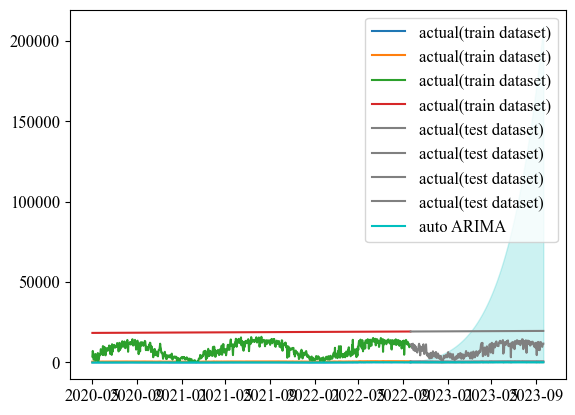

In [271]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[30:].timestamp, df_train[30:], label="actual(train dataset)")
ax.plot(df_test.timestamp, df_test, label="actual(test dataset)", color="gray")
ax.plot(df_train[30:].timestamp, train_pred[30:].values, color="c")
ax.plot(df_test.timestamp, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.timestamp,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

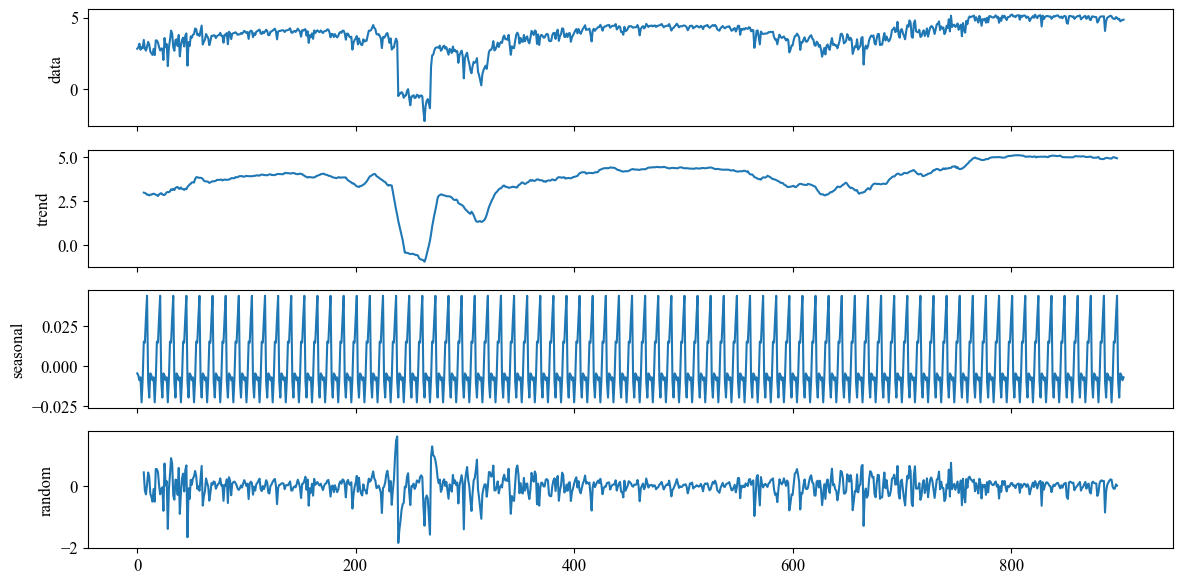

In [272]:
utils.decomposed_plot(arima.decompose(df_log, "additive", m=12),
                     figure_kwargs={"figsize":(14, 7)})

## dfを対数変換した
2021/1/1から2023/9/30をtrain, 2023/10/1から2023/11/30はtest

In [275]:
df["kappa_log"] = np.log(df["kappa"])
df.head()

,kappa,node,edge,timestamp,kappa_log
0,16.758163,471,2003,2020-04-01,2.818886
1,18.356171,487,2194,2020-04-02,2.909966
2,23.953381,514,2863,2020-04-03,3.176109
3,15.620315,470,1867,2020-04-04,2.748572
4,18.657366,495,2230,2020-04-05,2.926241


In [276]:
df.tail()

,kappa,node,edge,timestamp,kappa_log
1264,207.461811,707,10036,2023-09-17,5.334947
1265,200.619458,719,9705,2023-09-18,5.301410
1266,221.249877,705,10703,2023-09-19,5.399293
1267,241.694250,724,11692,2023-09-20,5.487673
1268,242.273060,736,11720,2023-09-21,5.490065


In [305]:
# train
train = df[(df["timestamp"] >= "2020-04-01") & (df["timestamp"] < "2023-05-01")]
# test
test = df[(df["timestamp"] >= "2023-05-01") & (df["timestamp"] <= "2023-09-21")]

In [282]:
train = train["kappa_log"].values
test = test["kappa_log"].values

In [299]:
sarima_mod = SARIMAX(train, order=(1,1,2), seasonal_order=(0,1,0,30))
sarima_fit = sarima_mod.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88981D-01    |proj g|=  1.51050D-02

At iterate    5    f=  7.88725D-01    |proj g|=  8.68895D-03

At iterate   10    f=  7.88126D-01    |proj g|=  1.26703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   7.302D-06   7.880D-01
  F =  0.78802836171110047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

min_lag = get_key_with_min_value(results_list)[0] + 1

forecast = np.exp(sarima_fit_log.forecast(len_test))
forecast.index = df_test.index

ax.plot(forecast, ls="-", color="r", label="predicted")
ax.plot(group_train.POWER, ls="-")

MAE:
0.4289743478724913
MAPE(%):
7.8358039373855535


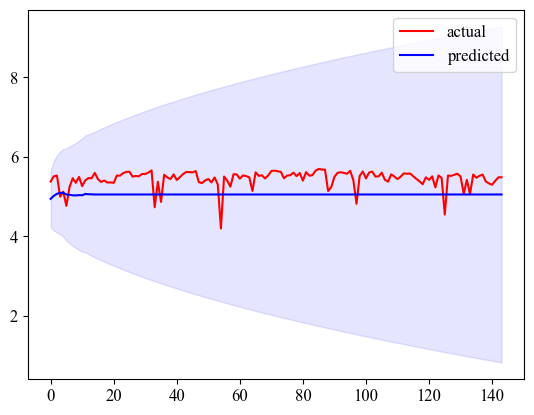

In [295]:
preds, conf_int = arima_model.predict(n_periods=test.shape[0],
                                     return_conf_int=True)

# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(np.mean(abs(test - preds)/test) *100)

# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()

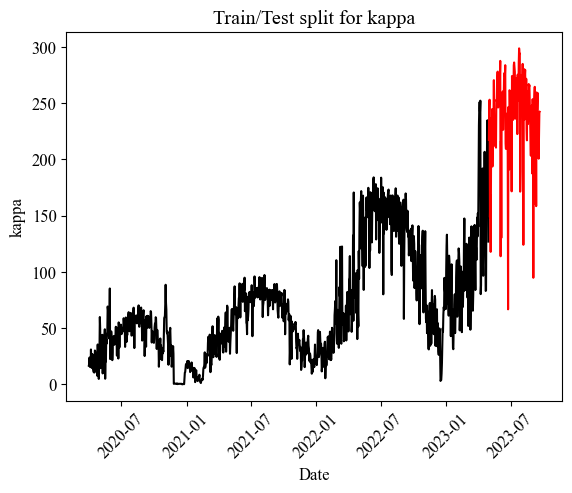

In [307]:
plt.plot(train["timestamp"], train["kappa"], color="black")
plt.plot(test["timestamp"], test["kappa"], color="red")
plt.ylabel("kappa")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Train/Test split for kappa")
plt.show()

In [308]:
y = train["kappa"]
ARMAmodel = SARIMAX(y, order=(1,0,1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36470D+00    |proj g|=  7.44085D-02

At iterate    5    f=  4.35589D+00    |proj g|=  6.34175D-03

At iterate   10    f=  4.35495D+00    |proj g|=  5.41669D-03

At iterate   15    f=  4.35410D+00    |proj g|=  1.62943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.401D-06   4.354D+00
  F =   4.3540956413390850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
